Inspiration:http://toddwschneider.com/posts/a-tale-of-twenty-two-million-citi-bikes-analyzing-the-nyc-bike-share-system/
Data links: 
1) cycle hire data: http://cycling.data.tfl.gov.uk/
2) locations lat lon: https://api-portal.tfl.gov.uk/docs
3) weather data
4) optional - demographic or economic data

EDA phases:
1) Clean up:
y - download csv of 2017 data
y- clean up data and remove unnecessary columns 
throw in last 2 weeks dec data
download json data of locations of bikes
check if locations match up or any missing locations
2) Aggregates and distributions:
big stats - average trip time, total rides, total stations, total bikes
stations - distribution of station by ride count, most popular stations to start, most popular stations to end, balancedness score and dist, most disbalanced
rides per day distributions - cdf, over time for full year (smoothen/rolling average), by day of week
rides over time through day by hour - by day of week
duration distributions - cdf, over time for full year (smoothen/rolling average)
duration by hour of day - by day of week
3) network interactions
start end pairs dataframe - aggregate up
heatmap/cosine similarity matrix
create network with nodes as bike stations
understand degrees and plot stations with highest degrees
plot of betweenness centrality
visualise network
4) effect of weather:
get weather data by hour
plot ride data by hour for different weather categories
regression with lagged rides, weather
5) map visual
map london 
add points based on stations
add color coding based on number of trips


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import glob
from pandas import Series
import squarify

In [3]:
path ='2017TripData' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
col_names = ['rental_id','duration','bike_id','end_date','end_station_id','end_station_name','start_date',
             'start_station_id','start_station_name']
df_list = []
for file_ in allFiles:
    df = pd.read_csv(file_,names=col_names,header=0,parse_dates=['start_date'],
                     dayfirst=True,infer_datetime_format=True)
    df_list.append(df)
frame=pd.concat(df_list)

In [4]:
frame.dtypes

rental_id                      int64
duration                     float64
bike_id                      float64
end_date                      object
end_station_id               float64
end_station_name              object
start_date            datetime64[ns]
start_station_id               int64
start_station_name            object
dtype: object

In [7]:
frame.shape

(9925010, 9)

In [8]:
frame.head(10)

,rental_id,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name
0,71414840,780.0,6324.0,16/11/2017 17:49,173.0,"Waterloo Road, South Bank",2017-11-16 17:36:00,199,"Great Tower Street, Monument"
1,71364210,300.0,15155.0,15/11/2017 08:08,24.0,"British Museum, Bloomsbury",2017-11-15 08:03:00,65,"Gower Place , Euston"
2,71458500,720.0,9436.0,18/11/2017 10:49,206.0,"New Road 1 , Whitechapel",2017-11-18 10:37:00,565,"Selby Street, Whitechapel"
3,71521376,1320.0,5151.0,21/11/2017 09:05,359.0,"Butler Place, Westminster",2017-11-21 08:43:00,701,"Vicarage Crescent, Battersea"
4,71489373,780.0,1270.0,20/11/2017 07:55,610.0,"Danvers Street, West Chelsea",2017-11-20 07:42:00,665,"Smugglers Way, Wandsworth"
5,71455551,360.0,7066.0,18/11/2017 02:49,24.0,"British Museum, Bloomsbury",2017-11-18 02:43:00,214,"Endsleigh Gardens, Euston"
6,71474318,1200.0,11946.0,19/11/2017 12:52,356.0,"South Kensington Station, South Kensington",2017-11-19 12:32:00,616,"Aintree Street, Fulham"
7,71493455,480.0,13205.0,20/11/2017 08:57,24.0,"British Museum, Bloomsbury",2017-11-20 08:49:00,14,"Belgrove Street , King's Cross"
8,71437069,300.0,8645.0,17/11/2017 12:24,88.0,"Bayley Street , Bloomsbury",2017-11-17 12:19:00,116,"Little Argyll Street, West End"
9,71362314,1560.0,9720.0,15/11/2017 07:50,556.0,"Heron Quays DLR, Canary Wharf",2017-11-15 07:24:00,314,"Tyers Gate, Bermondsey"


In [9]:
df3 = frame.groupby(['start_station_name']).size().reset_index(name='counts')
df3=df3.sort_values(by=['counts'],ascending=False)
df3.head(10)

,start_station_name,counts
60,"Belgrove Street , King's Cross",93408
358,"Hyde Park Corner, Hyde Park",86263
754,"Waterloo Station 3, Waterloo",80918
77,"Black Lion Gate, Kensington Gardens",61005
15,"Albert Gate, Hyde Park",59209
752,"Waterloo Station 1, Waterloo",55983
711,"Triangle Car Park, Hyde Park",49796
347,"Hop Exchange, The Borough",45341
758,"Wellington Arch, Hyde Park",43534
790,"Wormwood Street, Liverpool Street",42736


In [10]:
squarify.plot(sizes=df3['counts'], label=df3['start_station_name'], alpha=.8 )
plt.axis('off')

AttributeError: module 'squarify' has no attribute 'plot'

In [28]:
df4 = frame.groupby(['end_station_name']).size().reset_index(name='counts')
df4=df4.sort_values(by=['counts'],ascending=False)
df4.head(10)

,end_station_name,counts
60,"Belgrove Street , King's Cross",90568
358,"Hyde Park Corner, Hyde Park",85409
755,"Waterloo Station 3, Waterloo",76963
347,"Hop Exchange, The Borough",62005
15,"Albert Gate, Hyde Park",59009
77,"Black Lion Gate, Kensington Gardens",58922
753,"Waterloo Station 1, Waterloo",51028
105,"Brushfield Street, Liverpool Street",49625
342,"Holborn Circus, Holborn",49545
712,"Triangle Car Park, Hyde Park",48850


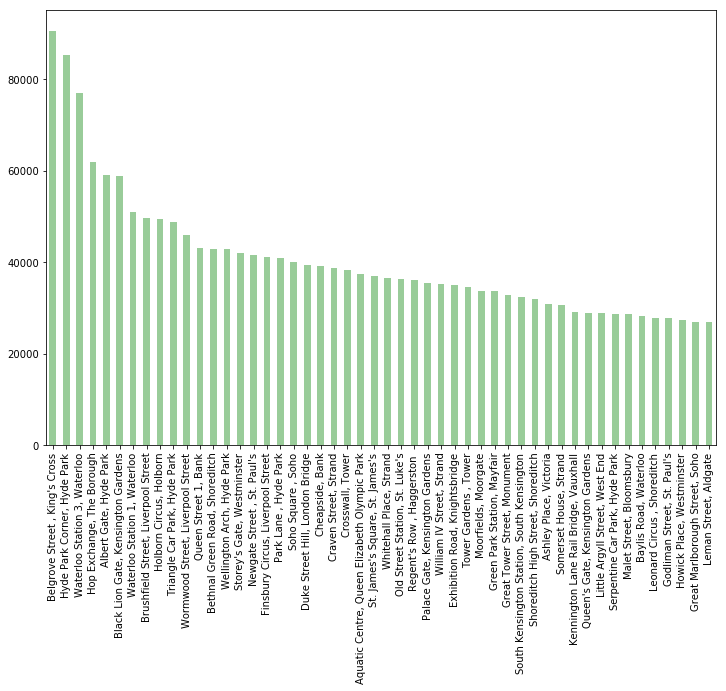

In [72]:
#df4.head(50).plot(kind='bar',ax=ax)
ax = df4.head(50)['counts'].plot(kind='bar', color='g', alpha=0.4,figsize=(12,8))
ax.set_xticklabels(df4.head(50)['end_station_name']);

In [34]:
df2 = frame[['start_date','duration']]
df2.index=frame['start_date']
hires_by_day = df2.resample('D').size().reset_index(name='trips')

In [95]:
df3 = frame['duration']
ax.hist(frame['duration'].dropna(), bins='auto', facecolor='g', edgecolor='none', alpha=0.5)

KeyboardInterrupt: 

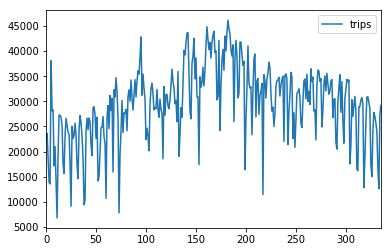

In [54]:
hires_by_day.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2511435f8>]], dtype=object)

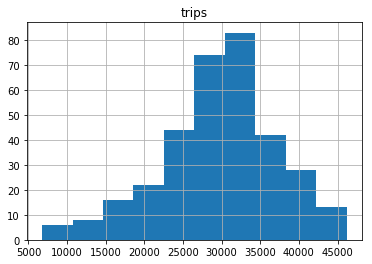

In [55]:
hires_by_day.hist()

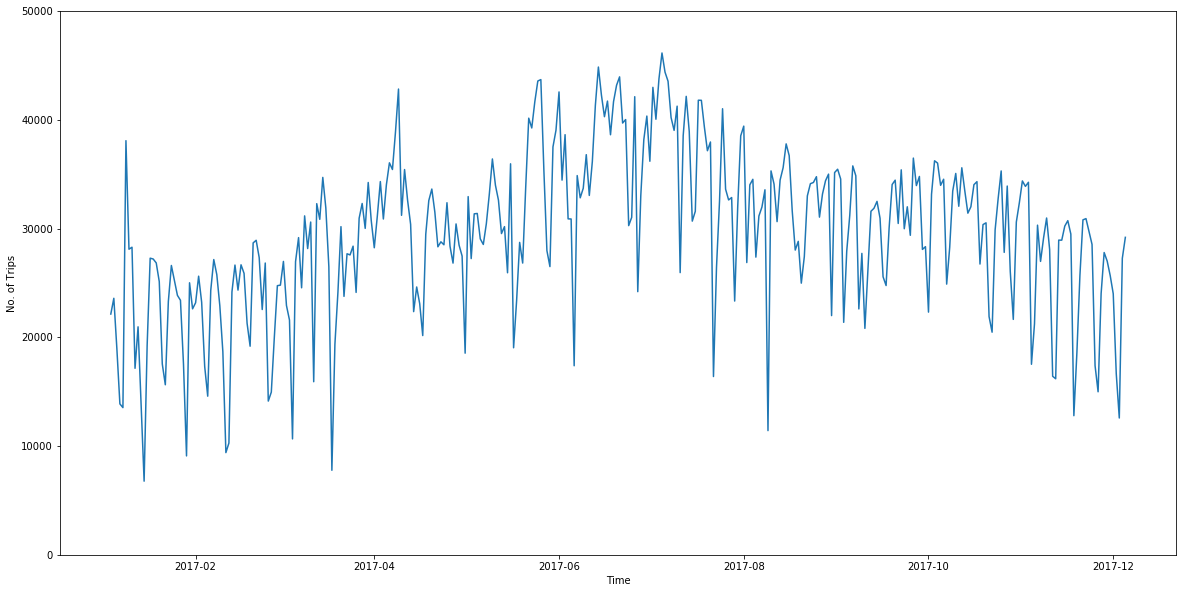

In [83]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(hires_by_day['start_date'],hires_by_day['trips'])
ax.set_xlabel('Time')
ax.set_ylabel('No. of Trips')
ax.set_ylim([0,50000]);

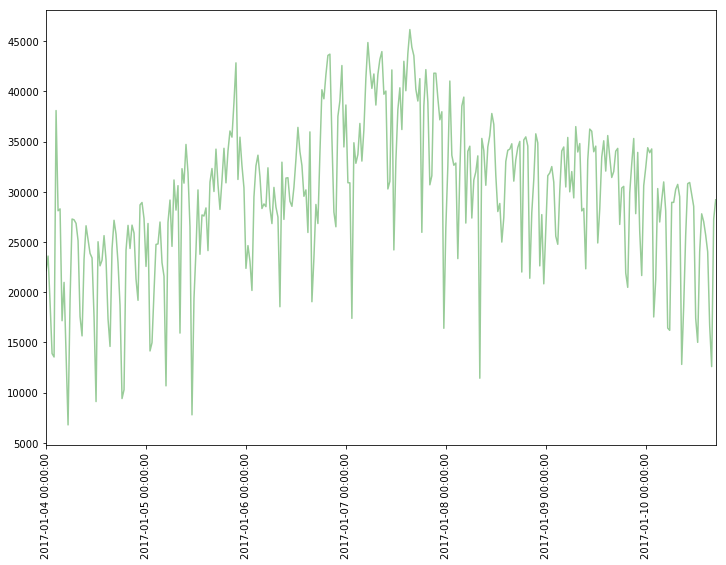

In [75]:
ax = hires_by_day['trips'].plot(kind='line', color='g', alpha=0.4,figsize=(12,8))
ax.set_xticklabels(hires_by_day['start_date'],rotation='vertical');